# Dynamical Xray Scattering

## Setup

In [1]:
import udkm1Dsim as ud
u = ud.u #  import the pint unit registry from udkm1Dsim
import scipy.constants as constants
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
u.setup_matplotlib() #  use matplotlib with pint units

## Atom creation

Initialize all required atoms using the `Atom` class.

In [2]:
O = ud.Atom('O')
Ti = ud.Atom('Ti')
Sr = ud.Atom('Sr')
Ru = ud.Atom('Ru')
Pb = ud.Atom('Pb')
Zr = ud.Atom('Zr')

## Unit cell creation

Create all required unit cells using the `UnitCell` class and add `Atom` objects to them.

In [3]:
# c-axis
c_STO_sub = 3.905*u.angstrom
c_SRO = 3.94897*u.angstrom
# sound velocity
sv_SRO = 6.312*u.nm/u.ps
sv_STO = 7.800*u.nm/u.ps

# property dict for SrRuO3
propSRO = {}
propSRO['a_axis'] = c_STO_sub # aAxis
propSRO['b_axis'] = c_STO_sub # bAxis
propSRO['deb_Wal_Fac'] = 0 # Debye-Waller factor
propSRO['sound_vel'] = sv_SRO # sound velocity
propSRO['opt_pen_depth'] = 43.8*u.nm # optical penetration depth
propSRO['therm_cond'] = 5.72*u.W/(u.m *u.K) # heat conductivity
propSRO['lin_therm_exp'] = 1.03e-5 # linear thermal expansion
propSRO['heat_capacity'] = 'lambda T: 455.2 + 0.112*T - 2.1935e6/T**2' # heat capacity [J/kg K]

# create unit cell object
SRO = ud.UnitCell('SRO', 'SRO', c_SRO, **propSRO)
# add atoms to unit cell at relative z-positions
SRO.add_atom(O, 0)
SRO.add_atom(Sr, 0)
SRO.add_atom(O, 0.5)
SRO.add_atom(O, 0.5)
SRO.add_atom(Ru, 0.5)

# property dict for SrTiO3 substrate
propSTOsub = {}
propSTOsub['a_axis'] = c_STO_sub # aAxis
propSTOsub['b_axis'] = c_STO_sub # bAxis
propSTOsub['deb_Wal_Fac'] = 0 # Debye-Waller factor
propSTOsub['sound_vel'] = sv_STO # sound velocity
propSTOsub['opt_pen_depth'] = np.inf*u.nm # optical penetration depth
propSTOsub['therm_cond'] = 12*u.W/(u.m *u.K) # heat conductivity
propSTOsub['lin_therm_exp'] = 1e-5 # linear thermal expansion
propSTOsub['heat_capacity'] = 'lambda T: 733.73 + 0.0248*T - 6.531e6/T**2' # heat capacity [J/kg K]

# create unit cell object
STO_sub = ud.UnitCell('STOsub', 'STOsub', c_STO_sub, **propSTOsub)
# add atoms to unit cell at relative z-positions
STO_sub.add_atom(O, 0)
STO_sub.add_atom(Sr, 0)
STO_sub.add_atom(O, 0.5)
STO_sub.add_atom(O, 0.5)
STO_sub.add_atom(Ti, 0.5)

## Structure creation

Create an actual sample using the `Structure` class and add `UnitCell` objects to it.

In [4]:
S = ud.Structure('Single Layer')
S.add_sub_structure(SRO, 100) # add 100 layers of SRO to sample
S.add_sub_structure(STO_sub, 1000) # add 1000 layers of STO substrate

substrate = ud.Structure('STO substrate')
substrate.add_sub_structure(STO_sub, 1000000)

S.add_substrate(substrate)

distances, _, _ = S.get_distances_of_layers() # distance vecotor of all unit cells

## Strain map creation

Since the `Heat` and `Phonon` simulations are not implemented, yet, the `strain_map` is created by a simple script, which mimics a strain wave traveling into the sample.

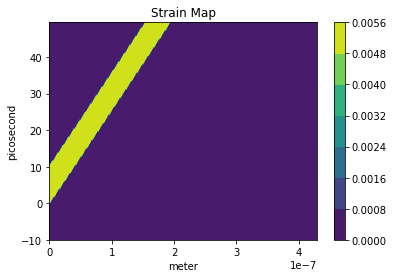

In [5]:
delays = np.r_[-10:50:0.5]*u.ps #  define the delays of the simulations
strain_map = np.zeros([len(delays), S.get_number_of_layers()]) #  allocate size of the strain_map

for i, delay in enumerate(delays):
    factor = 10
    width = 100
    if delay > 0:
        end = int(delay.magnitude * factor)
        start = end - width
        if start < 0: start = 0
        if end < 0: end = 0
        strain_map[i, start:end] = 0.005

# strain_vectors are a subset of the strain_map and are required to speed up the xray simulations
strain_vectors =  [np.array(np.linspace(np.min(strain_map), np.max(strain_map), 100))]*S.get_number_of_unique_layers()

# plot the artifical strain_map
plt.figure()
plt.contourf(distances, delays, strain_map)
plt.title('Strain Map')
plt.colorbar()
plt.show()

## Initialize dynamical Xray simulation

Create a dynamical Xray simulation using the `XrayDyn` class and add a `Structure` object as sample.
Also set the photon energy and $q_z$ range for the actual simulations.

In [6]:
force_recalc = True #  always recalculate results and do not consider cached results
dyn = ud.XrayDyn(S, force_recalc)
dyn.disp_messages = True #  enable displaying messages from within the simulations
dyn.save_data = False #  do not save results for caching

incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized


## Homogeneous Xray simulation

For the case of homogeneously strained samples, the dynamical Xray scattering simulations can be greatly simplyfied, which saves a lot of computational time.

### $q_z$-scan

Calculating _homogenous_reflectivity_ ...
Elapsed time for _homogenous_reflectivity_: 0.321848 s


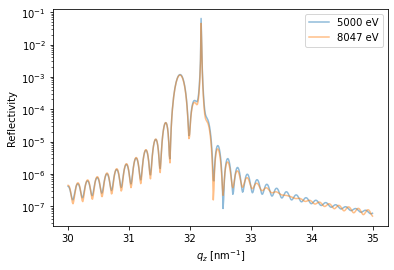

In [7]:
dyn.energy = np.r_[5000, 8047]*u.eV #  set two photon energies
dyn.qz = np.r_[3:3.5:0.001]/u.angstrom #  qz range

R_hom, A = dyn.homogeneous_reflectivity() #  this is the actual calculation

plt.figure()
plt.semilogy(dyn.qz[0, :], R_hom[0, :], label='{}'.format(dyn.energy[0]), alpha=0.5)
plt.semilogy(dyn.qz[1, :], R_hom[1, :], label='{}'.format(dyn.energy[1]), alpha=0.5)
plt.ylabel('Reflectivity')
plt.xlabel('$q_z$ [nm$^{-1}$]')
plt.legend()
plt.show()

### Post-Processing

Simple convolution of the results with an arbitrary function handle.

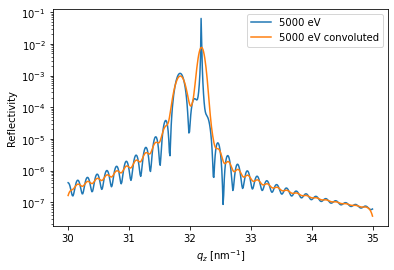

In [8]:
FWHM = 0.01/1e-10 # Angstrom
sigma = FWHM /2.3548
        
handle = lambda x: np.exp(-((x)/sigma)**2/2)
y_conv = dyn.conv_with_function(R_hom[0,:], dyn._qz[0,:], handle)

plt.figure()
plt.semilogy(dyn.qz[0,:], R_hom[0,:], label='{}'.format(dyn.energy[0]))
plt.semilogy(dyn.qz[0,:], y_conv, label='{} convoluted'.format(dyn.energy[0]))
plt.ylabel('Reflectivity')
plt.xlabel('$q_z$ [nm$^{-1}$]')
plt.legend()
plt.show()

### Energy-scan

c:\users\schick\general\git\udkm1dsim\udkm1Dsim\simulations\xrays.py:217: RuntimeWarning: invalid value encountered in arcsin
  self._theta = np.arcsin(np.outer(self._wl, self._qz[0, :])/np.pi/4)


Calculating _homogenous_reflectivity_ ...
Elapsed time for _homogenous_reflectivity_: 7.361013 s


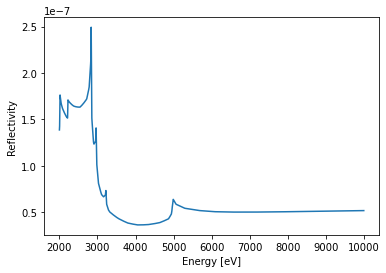

In [9]:
dyn.energy = np.r_[2000:10000]*u.eV #  set the energy range
dyn.qz = np.r_[1]/u.angstrom # qz range

R_hom, A = dyn.homogeneous_reflectivity() #  this is the actual calculation

plt.figure()
plt.plot(dyn.energy, R_hom[:, 0])
plt.ylabel('Reflectivity')
plt.xlabel('Energy [eV]')
plt.show()

## Sequential dynamical Xray simulation

Do a time-resolved xray scatting simulation for the above defined `strain_map` without parallelization.

In [10]:
dyn.energy = np.r_[5000, 8047]*u.eV #  set two photon energies
dyn.qz = np.r_[3:3.5:0.001]/u.angstrom #  qz range
R_seq = dyn.inhomogeneous_reflectivity(strain_map, strain_vectors, calc_type='sequential')

Calculating _inhomogenousReflectivity_ ...
Calculate all _ref_trans_matricies_ ...
Elapsed time for _ref_trans_matricies_: 9.356866 s



Elapsed time for _inhomogenous_reflectivity_: 75.919856 s


### Sequential Results

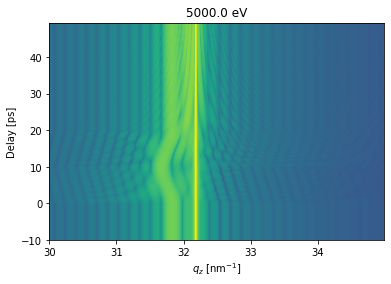

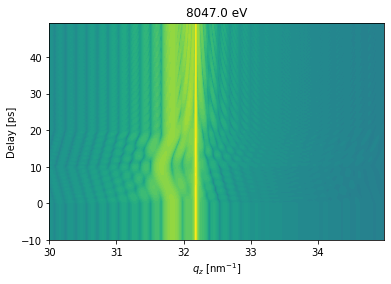

In [11]:
for i, energy in enumerate(dyn.energy):
    plt.figure()
    plt.contourf(dyn.qz[i,:], delays, np.log10(R_seq[:, i, :]), levels=100)
    plt.title('{:0.1f} eV'.format(energy.magnitude))
    plt.ylabel('Delay [ps]')
    plt.xlabel('$q_z$ [nm$^{-1}$]')
    plt.show()

## Parallel dynamical Xray scattering

You need to install the `udkm1Dsim` with the `parallel` option which essentially add the Dask package to the requirements:

```
> pip install udkm1Dsim[parallel]
```

You can also install/add Dask manually, e.g. via pip:

```
> pip install dask
```

Please refer to the [Dask documentation](https://docs.dask.org/en/latest/) for more details on parallel computing in Python.


Calculating _inhomogenousReflectivity_ ...
Calculate all _ref_trans_matricies_ ...
Elapsed time for _ref_trans_matricies_: 10.734430 s
Elapsed time for _inhomogenous_reflectivity_: 56.374650 s


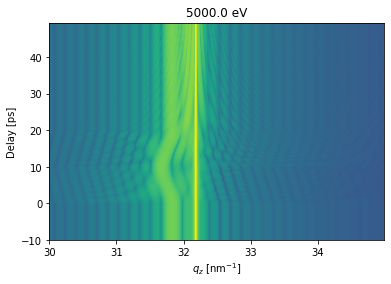

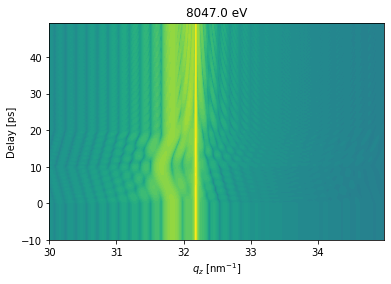

In [12]:
try:
    from dask.distributed import Client
    client = Client()

    R_par = dyn.inhomogeneous_reflectivity(strain_map, strain_vectors, calc_type='parallel', dask_client=client)

    for i, energy in enumerate(dyn.energy):
        plt.figure()
        plt.contourf(dyn.qz[i,:], delays, np.log10(R_par[:, i, :]), levels=100)
        plt.title('{:0.1f} eV'.format(energy.magnitude))
        plt.ylabel('Delay [ps]')
        plt.xlabel('$q_z$ [nm$^{-1}$]')
        plt.show()
except:
    pass